# Auswertung

In [1]:
#Importieren von allen benötigten Modulen

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import chi2
import io
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = 16, 9

## Teil 1: Messung des Nulleffekts

Der Nulleffekt, bezieht sich auf die tatsache das es an jedem Ort eine gewissen Grundaktivität gibt, diese macht es unmöglich irgendwann eine Zählrate von null, zu messen. Bei den folgenden Versuchen zur Absorbtion, werden wir deshalb davon ausgehen das die Strahlung der radioaktiven Quellen dann absorbiert wurde wenn wir nurnoch die Grundaktivität oder weniger messen werden. Diese Messung ist also notwendig für das weitere Vorgehen.

In [19]:
#Betriebsspannung
U1=550 #V
U1_err=6 #V

#Zerfälle in 5 Minuten = 300s
n0=95
n0_err=np.sqrt(n0)

#Normierung auf Zerfälle/Sekunde
n0_s=n0/300
n0_s_err=n0_err/300

print('Die Messung der Grundaktivität im Versuchsraum zu Versuchsbeginn:')
print()
print('n0 = ', n0, ' ± ', n0_err)
print('n0_red = ', n0_s, ' ± ', n0_s_err)

Die Messung der Grundaktivität im Versuchsraum zu Versuchsbeginn:

n0 =  95  ±  9.746794344808963
n0_red =  0.31666666666666665  ±  0.03248931448269654


\begin{align}
    n_0 &= 95 \pm 10 \ \text{[1/5min]}\\
    n_0^{red} &= 0.317 \pm 0.032 \ \text{[1/sec]}
\end{align}

## Teil 2: Absorption von $\beta$-Strahlung in Aluminium

Wichtig bei dieser Messung ist, dass die Abschirmung am Detektor montiert wurde und nicht an der Probe. Dadurch sinkt die Zählrate unter dem Wert der Nullmessung $n_0$.

In [3]:
#Kennnummer des Präparats: CT 872

#Anzahl Zerfälle
n_beta=np.array([823,534,338,244,142,84 ,84 ,58 ,46 ,24, 74, 64, 45, 38,113])
n_beta_err=np.sqrt(n_beta)

#Torzeit
T =    np.array([30 ,30 ,30 ,30 ,30 ,30 ,30 ,30 ,30,30 ,120,120,120,120,300])

#Absorberdicke in mm
x1 =   np.array([0  ,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,3.0,3.3,3.6,3.9,4.6])
x1_err = np.ones(n_beta.size)*0.2

#aus letztem Messwert wird n0_beta bestimmt, n0_beta in Zerfälle/s
n0_beta=n_beta[-1]/300
n0_beta_err=n_beta_err[-1]/300

#Abzug der Nullmessung unter Berücksichtigung der jeweiligen Torzeit, angegeben in Zerfälle/s
n_beta_korr=n_beta/T-n0_beta
n_beta_korr_err=np.sqrt((n_beta_err/T)**2+n0_beta_err**2)

### Fitfunktion

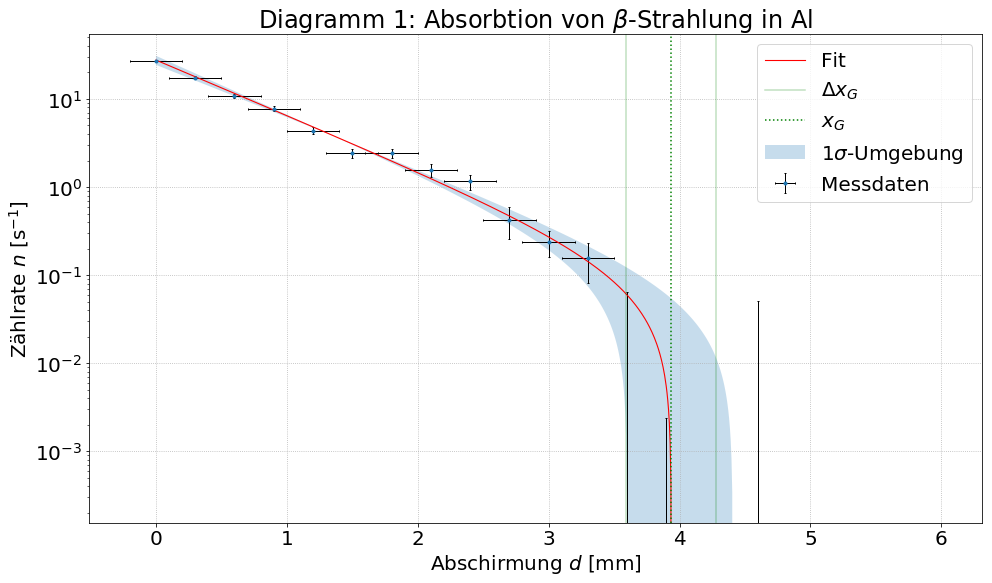

mu = 1.4436024850325357  ±  0.08146009754479987 [1/mm]
n0_beta = 0.09439013674250579  ±  0.03390650291974597  [1/sec]
A = 27.74856512063602  ±  3.2918750265207075  [1/sec]

x_G = 3.9370275996112505  ±  0.3435496188614603  [mm]

Chi-Quadrat = 5.639594243836465
Freiheitsgrade = 12
Chi-Quadrat reduziert = 0.46996618698637205
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten = 93.0 %


In [4]:
from scipy import odr

def fit_func(p, x):

    mu, n0_beta, A = p
    return A*np.exp(-x*mu)-n0_beta

model = odr.Model(fit_func)

#darzustellende Daten
x = x1
y = n_beta_korr
delta_x = x1_err
delta_y = n_beta_korr_err

#Startparameter
para0 = [1,1,1]

data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
odr = odr.ODR(data, model, beta0=para0 )
out = odr.run()

#1-Sigma
popt = out.beta
perr = out.sd_beta

#Sigma-Umgebung
nstd = 1 # um n-Sigma-Umgebung zu zeichnen
popt_top = popt+nstd*perr
popt_bot = popt-nstd*perr

#Plot-Umgebung
x_fit = np.linspace(0,6,1000)
fit = fit_func(popt, x_fit)
fit_top = fit_func(popt_top, x_fit)
fit_bot = fit_func(popt_bot, x_fit)

x_G = np.log(popt[2]/popt[1])/popt[0]
x_G_err = np.sqrt((1/(popt[0]*popt[2])*perr[2])**2 + 
                  (1/(popt[0]*popt[1])*perr[1])**2 + 
                  (np.log(popt[2]/popt[1])/(popt[0]**2)*perr[0])**2)

#Plot
fig, ax = plt.subplots(1)
plt.errorbar(x, y, yerr=delta_y, xerr=delta_x, lw=1, ecolor='k', fmt='.', capsize=1, label='Messdaten')
plt.title('Diagramm 1: Absorbtion von $\\beta$-Strahlung in Al')
plt.grid(linestyle='dotted')
plt.yscale('log')
plt.xlabel('Abschirmung $d$ [mm]')
plt.ylabel('Zählrate $n$ [s$^{-1}$]')
plt.plot(x_fit, fit, 'r', lw=1.1, label='Fit')
plt.axvline(x=x_G-x_G_err, color='g', alpha=.25, label=r'$\Delta {x_G}$')
plt.axvline(x=x_G+x_G_err, color='g', alpha=.25)
plt.axvline(x=x_G, color='g', linestyle=':', label=r'${x_G}$')
ax.fill_between(x_fit, fit_top, fit_bot, alpha=.25, label=str(nstd)+r'$\sigma$'+'-Umgebung')
plt.legend(loc='best')
plt.show()

from scipy.stats import chi2

dof = x.size-popt.size
chisquare = np.sum(((fit_func(popt, x)-y)**2)/
                   (delta_y**2+((fit_func(popt, x+delta_x)-fit_func(popt, x-delta_x))/2)**2))
chisquare_red = chisquare/dof
prob = round(1-chi2.cdf(chisquare,dof),2)*100

print('mu =', popt[0], ' ± ', perr[0], '[1/mm]')
print('n0_beta =', popt[1], ' ± ', perr[1], ' [1/sec]')
print('A =', popt[2], ' ± ', perr[2], ' [1/sec]')
print()
print('x_G =', x_G , ' ± ', x_G_err , ' [mm]')
print()                    
print('Chi-Quadrat =', chisquare)
print('Freiheitsgrade =', dof)
print('Chi-Quadrat reduziert =', chisquare_red)
print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten =', prob, '%')

### Flächendichte

Die Flächendichte $R_{\beta}$ ergibt sich aus:

\begin{align}
    R_\beta = \rho_{Al} \cdot x_G + R^\beta_{ES}
\end{align}

In [5]:
rho_alu=2.6989 # [g/cm^3]
R_beta_ES=0.130 # [g/cm^2]

R_beta=rho_alu*x_G+R_beta_ES
R_beta_err=rho_alu*x_G_err

print('Die Flächendichte R_beta berechnet sich zu:')
print('R_beta = (',R_beta,' ± ',R_beta_err,') [g/cm^2]')

E_max=1.8 #MeV
E_max_err=0.2
print('Dies entspricht einer Maximalenergie von E_max = ',E_max,'±',E_max_err,' [MeV]')
print()

#Vergleich mit Literaturwert Diagramm 8 liefert:
E_max_lit=2.274 #MeV

diff=np.abs(E_max-E_max_lit)
diff_err=E_max_err

print('Der Vergleich mit dem Literaturwert von ' + str(E_max_lit) + ' [MeV] liefert:')
print('diff_E_max = ' + str(diff) + ' ± ' + str(diff_err)+ ' [MeV] \n=> sigma = ',round(diff/diff_err,2))

Die Flächendichte R_beta berechnet sich zu:
R_beta = ( 10.755643788590804  ±  0.9272060663451952 ) [g/cm^2]
Dies entspricht einer Maximalenergie von E_max =  1.8 ± 0.2  [MeV]

Der Vergleich mit dem Literaturwert von 2.274 [MeV] liefert:
diff_E_max = 0.474 ± 0.2 [MeV] 
=> sigma =  2.37


\begin{align}
    R_\beta &= 17.220 \pm 3.132 \ \text{[g/cm$^2$]}\\
    \Rightarrow E_{max} &= 1.8 \pm 0.2 \ \text{[MeV]}\\
\end{align}

\begin{align}
    E_{max}^{lit} &= 2.274 \ \text{[MeV]}\\
    & \Rightarrow 2.37 \sigma
\end{align}

## Teil 3: Absorption von $\gamma$-Strahlung in Blei

Bei dieser Messung wurde die Abschirmung an der Probe montiert und nicht an dem Detektor, dadurch entstehen keine Werte unterhalb des Wertes der Nullmessung $n_0$.

In [6]:
#Kennnummer des Präparats: A SN375

#Anzahl Zerfälle
n_gamma=np.array([1107,748,547,417,350,237,167,137,102,92,72])
n_gamma_err=np.sqrt(n_gamma)

#Torzeit immer 60s

#Absorberdicke in cm
x2 = np.array([0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0])
x2_err = np.ones(x2.size)*0.02 

#Abzug der Nullmessung unter Berücksichtigung der jeweiligen Torzeit
n_gamma_korr=1/60*(n_gamma-(n0_s*60)*np.ones(n_gamma.size))  #in Zerfälle/s
n_gamma_korr_err=1/60*np.sqrt(n_gamma_err**2+(60*n0_s_err*np.ones(n_gamma.size))**2)

### Fitfunktion

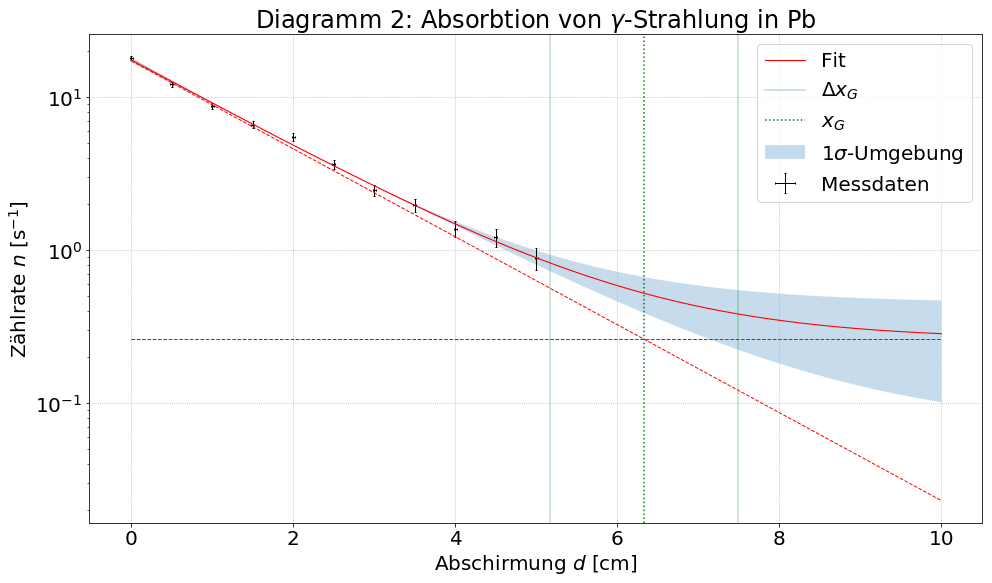

mu = 0.6625790725856205  ±  0.03559706992119007 [1/cm]
n0_gamma = 0.26072677363239616  ±  0.19153455703618955  [1/sec]
 => n0_gamma_min = 16.0  ±  11.492  [1/min]
A = 17.309006852451137  ±  0.4530444037815156  [1/sec]

x_G = 6.33208839703506  ±  1.160414431423299  [cm]

Chi-Quadrat = 8.42258957854384
Freiheitsgrade = 8
Chi-Quadrat reduziert = 1.05282369731798
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten = 39.0 %


In [7]:
from scipy import odr

def fit_func(p, x):

    mu, n0_gamma, A = p
    return A*np.exp(-x*mu)+n0_gamma
    

model = odr.Model(fit_func)

#darzustellende Daten
x = x2
y = n_gamma_korr
delta_x = x2_err
delta_y = n_gamma_korr_err

#Startparameter
para0 = [1,1,1]

data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
odr = odr.ODR(data, model, beta0=para0 )
out = odr.run()

#1-Sigma
popt = out.beta
perr = out.sd_beta

#Sigma-Umgebung
nstd = 1 # um n-Sigma-Umgebung zu zeichnen
popt_top = popt+nstd*perr
popt_bot = popt-nstd*perr

#Plot-Umgebung
x_fit = np.linspace(0,10,1000)
fit = fit_func(popt, x_fit)
fit_top = fit_func(popt_top, x_fit)
fit_bot = fit_func(popt_bot, x_fit)
subfit_1 = popt[2]*np.exp(-x_fit*popt[0])
subfit_2 = np.full(x_fit.size, popt[1])

x_G = np.log(popt[2]/popt[1])/popt[0]
x_G_err = np.sqrt((1/(popt[0]*popt[2])*perr[2])**2 + 
                  (1/(popt[0]*popt[1])*perr[1])**2 + 
                  (np.log(popt[2]/popt[1])/(popt[0]**2)*perr[0])**2)

#Plot
fig, ax = plt.subplots(1)
plt.errorbar(x, y, yerr=delta_y, xerr=delta_x, lw=1, ecolor='k', fmt='none', capsize=1, label='Messdaten')
plt.title('Diagramm 2: Absorbtion von $\\gamma$-Strahlung in Pb')
plt.grid(linestyle='dotted')
plt.yscale('log')
plt.xlabel('Abschirmung $d$ [cm]')
plt.ylabel('Zählrate $n$ [s$^{-1}$]')
plt.plot(x_fit, fit, 'r', lw=1.1, label='Fit')
plt.axvline(x=x_G-x_G_err, color='g', alpha=.25, label=r'$\Delta {x_G}$')
plt.axvline(x=x_G+x_G_err, color='g', alpha=.25)
plt.axvline(x=x_G, color='g', linestyle=':', label=r'${x_G}$')
plt.plot(x_fit, subfit_1, 'r--', lw=1)
plt.plot(x_fit, subfit_2, 'r--', lw=1)
ax.fill_between(x_fit, fit_top, fit_bot, alpha=.25, label=str(nstd)+r'$\sigma$'+'-Umgebung')
plt.legend(loc='best')
plt.show()

from scipy.stats import chi2

dof = x.size-popt.size
chisquare = np.sum(((fit_func(popt, x)-y)**2)/
                   (delta_y**2+((fit_func(popt, x+delta_x)-fit_func(popt, x-delta_x))/2)**2))
chisquare_red = chisquare/dof
prob = round(1-chi2.cdf(chisquare,dof),2)*100

print('mu =', popt[0], ' ± ', perr[0], '[1/cm]')
print('n0_gamma =', popt[1], ' ± ', perr[1], ' [1/sec]')
print(' => n0_gamma_min =', round(popt[1]*60,0), ' ± ', round(perr[1]*60,3), ' [1/min]')
print('A =', popt[2], ' ± ', perr[2], ' [1/sec]')
print()
print('x_G =', x_G , ' ± ', x_G_err , ' [cm]')
print()                    
print('Chi-Quadrat =', chisquare)
print('Freiheitsgrade =', dof)
print('Chi-Quadrat reduziert =', chisquare_red)
print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten =', prob, '%')

### Schwächungskoeffizient

In [20]:
mu=popt[0]  #1/cm
mu_err=(perr[1])**0.5
print('Aus dem linearen Fit folgt für den Schwächungskoeffizienten:')
print('mu = (' + str(mu) + ' ± ' + str(mu_err) + ') 1/cm' )

#Massenschwächungskoeffizient
rho_pb=11.342 #g/cm^3

mu_rho=mu/rho_pb  #cm^2/g
mu_rho_err=mu_rho*(mu_err/mu)

print()
print('Für den materialunabhängigen Massenschwächungskoeffizienten mu/rho folgt:')
print('mu/rho = (' + str(mu_rho) + ' ± ' + str(mu_rho_err) + ') cm^2/g')
print()
#Ablesen der zugehörigen Energie aus Diagramm 9 in der Anleitung liefert:

E_gamma, E_gamma_err = 0.43, 0.1  # [MeV] 

#Vergleich mit Literaturwert (Diagramm 8) liefert:

E_gamma_lit = [1.173, 1.333]

for i in range(0,2): 
    diff = np.abs(E_gamma - E_gamma_lit[i])
    diff_err = E_gamma
    sig = diff/diff_err
    print('mögliche Energie: ', E_gamma_lit[i], 
          ' [MeV]\nMesswert: ', E_gamma, ' ± ', E_gamma_err,
          ' [MeV]\nDiff_E: ', diff, ' ± ', diff_err,
          ' [MeV]\n=> sigma =', sig)
    print()

Aus dem linearen Fit folgt für den Schwächungskoeffizienten:
mu = (-64.85925491166911 ± 19.04246091822835) 1/cm

Für den materialunabhängigen Massenschwächungskoeffizienten mu/rho folgt:
mu/rho = (-5.718502460912459 ± 1.6789332497115455) cm^2/g

mögliche Energie:  1.173  [MeV]
Messwert:  0.43  ±  0.1  [MeV]
Diff_E:  0.7430000000000001  ±  0.43  [MeV]
=> sigma = 1.7279069767441864

mögliche Energie:  1.333  [MeV]
Messwert:  0.43  ±  0.1  [MeV]
Diff_E:  0.903  ±  0.43  [MeV]
=> sigma = 2.1



Aus dem Fit folgt für den Schwächungskoeffizienten $\mu$:

\begin{align}
    \mu &= 0.6626 \pm 0.0356 \ \text{[1/cm]}\\
    \rho &= 11.342 \ \text{[cm$^3$/g]}\\
    & \Rightarrow \frac{\mu}{\rho} = 0.0584 \pm 0.0386 \ \text{[cm$^2$/g]}\\
    \\
    E_{mes} &= 0.43 \pm 0.1 \ \text{[MeV]} 
\end{align}

Die Werte der Energieberechnung sind: 

| Übergangsenergie    | $\Delta E$        | $\sigma$-Abw. |
|---------------------|-------------------|---------------|
| $E_1$ = 1.173 [MeV] | 0.743 $\pm$ 0.430 | 1.73          |
| $E_2$ = 1.333 [MeV] | 0.904 $\pm$ 0.430 | 2.10          |

## Teil 4: Aktivität des vorliegenden $\gamma$-Strahlers
### Rückrechnung vom Litteraturwert 

Der Herstellerangaben zur beziehen sich natürlich nur auf die am Herstellungsdatum gemessene Aktivität $A_0$, welche mit der Zeit exponentiell nachlässt. Durch die bekannte Halbwertszeit des Präparats kann man die nun die erwartete Aktivität am Versuchstag berechnen und schauen wie stark diese von den Herstellerangaben abweicht. Die Aktivität bei der Herstellung des Präparats am 2.3.2010, wurde angegeben als: 

\begin{align}
    A_0 = 3700 \ \text{[kBq]}
\end{align}

In [9]:
# Herstellerangabe: 3700kBq am 2.3.2010

A0=3700e3 #Bq

# Versuchsdatum: 9.3.2022; Differenz: 4418 ± 1* dys => 12.1041 yrs 
# *(je nachdem ob man den Versuchstag dazuzählt)

del_t=12.1041 # yrs
del_t_err=1/365

# Halbwertszeit nach Skript T12=5.27 yrs

T12=5.27 # yrs

# Aktivität am Versuchstag

A_lit = A0*np.exp(-np.log(2)*del_t/T12)
A_lit_err = (np.log(2)*A0*np.exp(-(np.log(2)*del_t)/T12))/T12*del_t_err

print('Für die Aktivität A_lit des Gamma-Strahlers am Versuchstag folgt:')
print('A_lit = ', A_lit*1e-3, ' ± ', A_lit_err, ' [kBq]')

Für die Aktivität A_lit des Gamma-Strahlers am Versuchstag folgt:
A_lit =  753.0053926239844  ±  271.34390311858255  [kBq]


Erwartete Aktivität am Versuchstag (Literaturwer): 
    
\begin{align}
    A_{lit} = 753 \pm 271 \ \text{[kBq]}
\end{align}

In [10]:
#Abstand Präparat und Zählrohr
d=np.array([0.05,0.10,0.20,0.30]) #m
d_err=8e-3*np.ones(d.size)

#registrierte Zerfälle, direkt in Zerfälle/s
N=1/60*np.array([15034,3886,990,456])
N_err=1/60*np.sqrt(60*N)

#Radius des Zählrohrs
r=7e-3 #m

#Raumwinkel
Omega=np.pi*r**2/d**2
Omega_err=Omega*2*d_err/d

#Ansprechwahrscheinlichkeit Zählrohr für gamma-Strahlung
epsilon= 0.04 
epsilon_err=epsilon*0.03

#Aktivität für gesamte Kugelfläche
A=0.5*4*N/epsilon*d**2/r**2 #Faktor 0.5, da 2 gamma-Quanten pro Zerfall
A_err=A*np.sqrt((N_err/N)**2+(d_err/d)**2+(epsilon_err/epsilon)**2)

print('Für die Aktivität A des Gamma-Strahlers folgt:')
for i in range(0,4):
    print('A_%d = ' %(d[i]*100) + str(A[i]*1e-3)+ ' ± '  + str(A_err[i]*1e-3)+' [kBq]')

Für die Aktivität A des Gamma-Strahlers folgt:
A_5 = 639.2006802721089 ± 104.18484009523695 [kBq]
A_10 = 660.8843537414967 ± 57.45261212602663 [kBq]
A_20 = 673.4693877551022 ± 39.90043835921868 [kBq]
A_30 = 697.9591836734693 ± 43.04826190426189 [kBq]


In [11]:
#Vergleich der Messwerte mit Literaturwert
diff_A = np.abs(A-A_lit)
diff_A_err = np.sqrt(A_err**2 + A_lit_err**2)

for i in range(0,4):
    print('Der Vergleich mit dem Literaturwert liefert:')
    print('diff_%d = '%(d[i]*100), diff_A[i]*1e-3, ' ± ', diff_A_err[i]*1e-3, ' [kBq]') 
    print('=> sigma =',(diff_A[i]/diff_A_err[i]).round(2))
    print()

Der Vergleich mit dem Literaturwert liefert:
diff_5 =  113.80471235187561  ±  104.18519344505653  [kBq]
=> sigma = 1.09

Der Vergleich mit dem Literaturwert liefert:
diff_10 =  92.12103888248781  ±  57.45325288978355  [kBq]
=> sigma = 1.6

Der Vergleich mit dem Literaturwert liefert:
diff_20 =  79.53600486888236  ±  39.90136098896338  [kBq]
=> sigma = 1.99

Der Vergleich mit dem Literaturwert liefert:
diff_30 =  55.04620895051526  ±  43.049117069827176  [kBq]
=> sigma = 1.28



Wir erhalten folgende Werte im vergelich zum Litteraturwert $A_{lit}$:

| Abstand $d$ [cm] | $A_{mes}$     | $\sigma$-Abw.  |
|------------------|---------------|----------------|
| 5                | 639 $\pm$ 104 | 1.09           |
| 10               | 661 $\pm$ 58  | 1.60           |
| 20               | 673 $\pm$ 40  | 1.99           |
| 30               | 698 $\pm$ 43  | 1.28           |

### Raumwinkel-Korrektur

In [12]:
#Länge l des Zählrohrs: l=4cm
l=4e-2 #m

#Korrekturfaktor k1=(1+0.5*l/d)**2
k1=(1+0.5*l/(d+7e-3))**2
k1_err=2*(1+0.5*l/(d+7e-3))*0.5*l/(d+7e-3)**2*d_err

#korrigierte Aktivität A_korr=A*k1
A_korr=A*k1
A_korr_err=A_korr*np.sqrt((A_err/A)**2+(k1_err/k1)**2)

#Vergleich der Messwerte mit Literaturwert
diff_A_korr=np.abs(A_korr-A_lit)
diff_A_korr_err=A_korr_err

print('Der Korrekturfaktor k1 und die korrigierte Aktivität A_korr ergeben sich zu:')
for i in range(0,4):
    print('k1_%d = '%(d[i]*100), k1[i], ' ± ', k1_err[i])
    print('A_korr_%d = '%(d[i]*100) + str(A_korr[i]*1e-3)+' ± '  + str(A_korr_err[i]*1e-3)+' [kBq]')
    print('=> sigma =',(diff_A_korr[i]/diff_A_korr_err[i]).round(2))
    print()

Der Korrekturfaktor k1 und die korrigierte Aktivität A_korr ergeben sich zu:
k1_5 =  1.82486919052016  ±  0.13305038527374147
A_korr_5 = 1166.457627988099 ± 208.27824583716048 [kBq]
=> sigma = 1.99

k1_10 =  1.4087693248318631  ±  0.03317434571684422
A_korr_10 = 931.0336048123505 ± 83.85436696523719 [kBq]
=> sigma = 2.12

k1_20 =  1.2025718219795094  ±  0.008189639767465642
A_korr_20 = 809.895308680078 ± 48.299093429779845 [kBq]
=> sigma = 1.18

k1_30 =  1.1345372364693525  ±  0.003616451161682981
A_korr_30 = 791.860683413303 ± 48.9050386203868 [kBq]
=> sigma = 0.79



### Absorptions-Korrektur

In [13]:
#Präparatkapseldaten
d1=0.14 #cm
rho_kapsel=7.9 #g/cm^3
#mu_rho aus vorherigem Aufgabenteil
mu_kapsel=mu_rho*rho_kapsel #1/cm
mu_kapsel_err=mu_kapsel*mu_rho_err/mu_rho

#Korrekturfaktor k2=exp(-mu*x)
k2=np.exp(-mu_kapsel*d1)
k2_err=k2*d*mu_kapsel_err

print('Der Korrekturfaktor k2 ergibt sich zu:')
print('k2 = ' + str(k2)+' ± '  + str(k2_err))
print()

#korrigierte Aktivität A_korr2=A_korr*k2
A_korr2=A_korr*k2
A_korr2_err=A_korr2*np.sqrt((A_korr_err/A_korr)**2+(k2_err/k2)**2)

#Vergleich der Messwerte mit Literaturwert
diff_A_korr2=np.abs(A_korr2-A_lit)
diff_A_korr2_err=A_korr2_err

print('Die korrigierte Aktivität A_korr2 ergibt sich zu:')
for i in range(0,4):
    print('A_korr2_%d = '%(d[i]*100) + str(A_korr2[i]*1e-3)+ ' ± ' + str(A_korr2_err[i]*1e-3)+' [kBq]') 
    print('=> sigma = ',(diff_A_korr2[i]/diff_A_korr2_err[i]).round(2))
    print()

Der Korrekturfaktor k2 ergibt sich zu:
k2 = 0.9374325087496878 ± [0.01428799 0.02857597 0.05715195 0.08572792]

Die korrigierte Aktivität A_korr2 ergibt sich zu:
A_korr2_5 = 1093.4753005550936 ± 195.95682921609517 [kBq]
=> sigma =  1.74

A_korr2_10 = 872.7811678895071 ± 82.98809513000013 [kBq]
=> sigma =  1.44

A_korr2_20 = 759.2221910405682 ± 64.74962882721718 [kBq]
=> sigma =  0.1

A_korr2_30 = 742.3159470323749 ± 81.91516701301678 [kBq]
=> sigma =  0.13



Für die Aktivität des $\gamma$-Strahlers haben wir folgende verglichen zum Litteraturwert folgende Werte erhalten:

| Abstand $d$ [cm] | $A_{mes}$     | $\sigma$-Abw.  | $A^{(RWK)}_{mes}$ | $\sigma$-Abw. | $A^{(AK)}_{mes}$ | $\sigma$-Abw. |
|------------------|---------------|----------------|-------------------|---------------|------------------|---------------|
| 5                | 639 $\pm$ 104 | 1.09           | 1167 $\pm$ 208    | 1.99          | 905 $\pm$ 212    | 0.71          |
| 10               | 661 $\pm$ 58  | 1.60           | 931 $\pm$ 84      | 2.12          | 722 $\pm$ 230    | 0.14          |
| 20               | 673 $\pm$ 40  | 1.99           | 809 $\pm$ 48      | 1.18          | 628 $\pm$ 385    | 0.32          |
| 30               | 698 $\pm$ 43  | 1.28           | 792 $\pm$ 49      | 0.79          | 614 $\pm$ 563    | 0.25          |

wobei (RWK) für die Raumwinkelkorrektur steht und (AK) für die Absorbtionskorrektur. 

## Teil 5: Absorptionsmessung und Energiebestimmung von $\alpha$-Strahlung

Hier wurde die Zählrate bei immer höheren Dichten (Druck) des Absorbermaterials aufgenommen. Auffällig dabei ist, dass die Zählrate sich bei zu gerigem Druck, kaum ändert und sogar höher wird (statistische Fluktuation). Wir vermuten als Ursache dafür die geringe Dichte von Luft bei $20-100$ [mbar] welche zu niedrig ist um zuverlässig einen signifikanten Teil der $\alpha$-Teilchen abzubremsen.
Die Anzahl der Stöße ist wahrscheinlich zu gering um eine messbare Abschirmung zu garantieren. 

In [14]:
#Anzahl Zerfälle
n_alpha = np.array([5676,5685,5507,5131,4995,4706,4398,3725,3003,2316,1669,1159,733,18])
n_alpha_err = np.sqrt(n_alpha)

#Torzeit immer 60s

#Druck in mbar
p = np.array([30.5,130,233,300.5,310.5,326.5,330,340,351,362.5,372.5,380,390.5,403]) # [mbar]
p_err = np.ones(p.size)*.5

### Fitfunktion

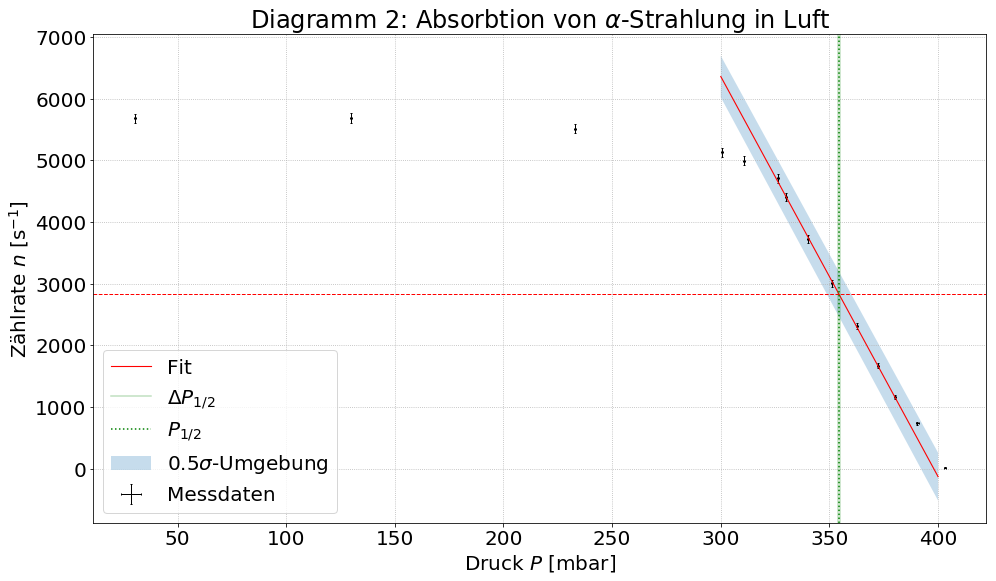

m = -64.85925491166911  ±  1.030126756901266 [1/(sec mbar)]
b = 25814.170269159724  ±  362.6153178222541  [1/sec]
P_half =  354.25425425425425  ±  0.49671106019377476  [mbar]

Chi-Quadrat = 73897.08298245474
Freiheitsgrade = 4
Chi-Quadrat reduziert = 18474.270745613685
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten = 0.0 %


In [15]:
from scipy import odr

def fit_func(p, x):

    m,b = p
    return m*x+b
    

model = odr.Model(fit_func)

#darzustellende Daten
x = p
y = n_alpha
delta_x = p_err
delta_y = n_alpha_err

#Startparameter
para0 = [1,1]
a,b = 5,11
data = odr.RealData(x[a:b], y[a:b], sx=delta_x[a:b], sy=delta_y[a:b])
#data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
odr = odr.ODR(data, model, beta0=para0 )
out = odr.run()

#1-Sigma
popt = out.beta
perr = out.sd_beta

#Sigma-Umgebung
nstd = .5 # um n-Sigma-Umgebung zu zeichnen
popt_top = popt+nstd*perr
popt_bot = popt-nstd*perr

#Plot-Umgebung
x_fit = np.linspace(300,400,1000) 
fit = fit_func(popt, x_fit)
fit_top = fit_func(popt_top, x_fit)
fit_bot = fit_func(popt_bot, x_fit)

def find_P_half(a,b,size): #Erlaubt es den Halbwertsdruck genauer zu bestimmen statt ihn abzuschätzen 
    D = []
    x_fit = np.linspace(a,b,size)
    fit = fit_func(popt, x_fit)
    for k in fit:
        d = np.abs(k-n_alpha[0]/2)
        D.append(d)
    for k in x_fit:
        n = fit_func(popt,k)
        d = np.abs(n-n_alpha[0]/2)
        if d == min(D):
            return [k,d]

P_half = find_P_half(300,400,1000)[0]
P_half_err = find_P_half(300,400,1000)[1]

#Plot
fig, ax = plt.subplots(1)
plt.errorbar(x, y, yerr=delta_y, xerr=delta_x, lw=1, ecolor='k',fmt='none', 
             capsize=1, label='Messdaten')
plt.title('Diagramm 3: Absorbtion von $\\alpha$-Strahlung in Luft')
plt.grid(linestyle='dotted')
#plt.yscale('log')
plt.xlabel('Druck $P$ [mbar]')
plt.ylabel('Zählrate $n$ [s$^{-1}$]')
plt.plot(x_fit, fit, 'r', lw=1.1, label='Fit')
plt.axvline(x=P_half-P_half_err, color='g', alpha=.25, label=r'$\Delta P_{1/2}$')
plt.axvline(x=P_half+P_half_err, color='g', alpha=.25)
plt.axvline(x=P_half, color='g', linestyle=':', label=r'$P_{1/2}$')
plt.axhline(y=n_alpha[0]/2, color='r', ls='--', lw=1)
ax.fill_between(x_fit, fit_top, fit_bot, alpha=.25, label=str(nstd)+r'$\sigma$'+'-Umgebung')
plt.legend(loc='best')
plt.show()

from scipy.stats import chi2

dof = x[a:b].size-popt.size
chisquare = np.sum(((fit_func(popt, x)-y)**2)/
                   (delta_y**2+((fit_func(popt, x+delta_x)-fit_func(popt, x-delta_x))/2)**2))
chisquare_red = chisquare/dof
prob = (1-chi2.cdf(chisquare,dof))*100

print('m =', popt[0], ' ± ', perr[0], '[1/(sec mbar)]')
print('b =', popt[1], ' ± ', perr[1], ' [1/sec]')
print('P_half = ', P_half, ' ± ', P_half_err, ' [mbar]')

print()                    
print('Chi-Quadrat =', chisquare)
print('Freiheitsgrade =', dof)
print('Chi-Quadrat reduziert =', chisquare_red)
print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten ='
      , round(prob,2), '%')

Aus der Fitgeraden wurde folgender Wert für den Halbwertsdruck abgelesen:

\begin{align}
    P_{1/2} = 354.3 \pm 0.5 \ \text{[mbar]}
\end{align}

### Berechnung der Reichweite $s_1$ von $\alpha$-Strahlung

Über dem Abfall der Zählrate mit dem Druck kann die Reichweite $s_1$ bei dem Halbwertsdruck $P_{1/2}$ errechnet werden über:

\begin{align}
    s_1 = \frac{P_{1/2}}{p_0} s_0
\end{align}

wobei $s_0$ der Abstand der Probe zum Detektor, und $p_0$ der Normaldruck ($p_0$ = 1013 mbar) ist. 

In [22]:
#Druck p1, bei dem die Zählrate auf die Hälfte abgefallen ist
p1 = P_half
p1_err = P_half_err
#Normaldruck
p0=1013 #mbar
#Abstand Präparat - Zählrohr
s0=4.45 #cm
s0_err=0.05

#Reichweite bei p1
s1=p1/p0*s0
s1_err=s1*np.sqrt((p1_err/p1)**2+(s0_err/s0)**2)

print('Mit dem Halbwertsdruck p1 folgt für die Reichweite:')
print('s_1 = ' + str(s1)+' ± '  + str(s1_err)+' [cm]')

Mit dem Halbwertsdruck P_half folgt für die Reichweite:
s_1 = 1.5562008207615317 ± 0.017621021997218836 [cm]


### Korrekturen

Die $\alpha$-Teilchen werden in diesem Aufbau zusätzlich noch einmal abgeschirmt. Zum einem muss die die Dicke des Zählrohrfensters aus Glimmer brücksichtigt werden, welches ein Bremsvermögen von 1.43 [mg/cm$^2$] besitzt. Dieser entspricht etwa dem Bremsvermögen von 1cm Luft unter Normalbedingungen. Mit der Flächendichte des Glimmerfensters $\rho_{GL}$ von 2.35 [mg/cm$^2$]erhöht sich die Reichweite $s_1$ um:

\begin{align}
    s_2 = \frac{\rho_{GL}}{1.43 \ \text{[mg/cm$^2$]}} \cdot 1 \ \text{[cm]}
\end{align}

Außerdem ist die $^{241}$Am-Quelle mit einer 3$\mu$m dicken Au-Schicht bedampft worden. Welches dem Bremsvermögen von 0.68cm Luft unter Normalbedingungen gleichkommt.

\begin{align}
    s_3 = 0.63 \ \text{[cm]}
\end{align}

In [17]:
#Flächendichte Glimmerfenster
rho_Gl=2.35 #mg/cm^2
s2=rho_Gl/1.43 #cm

#Schutzschicht aus Gold
s3=0.68 #cm

s_ges=s1+s2+s3
s_ges_err=s1_err

print('Die Gesamtreichweite ergibt sich zu:')
print('s_ges = ' + str(s_ges)+' ± '  + str(s_ges_err)+' [cm]')

Die Gesamtreichweite ergibt sich zu:
s_ges = 3.8795574641181756 ± 0.017621021997218836 [cm]


### Energiemessung

Aus dem Zerfallsdiagramm \ref{fig:Zerfallsdiagramm alpha} folgt die erwartete Energie der $\alpha$-Teilchen von:

\begin{align}
    E_\alpha^{lit} = 5.43 \ \text{[MeV]}
\end{align}

In [18]:
#Aus Diagramm 8 ergibt sich eine Energie von E_alpha= 5.6 ± 0.2 MeV
E_alpha=5.3 #MeV
E_alpha_err=0.2

#Vergleich mit Literaturwert (aus Skript) liefert:
E_alpha_lit=5.48 #MeV

diff2=np.abs(E_alpha-E_alpha_lit)
diff2_err=E_alpha_err

print('Der Vergleich mit dem Literaturwert von '+str(E_alpha_lit)+' [MeV] liefert:')
print('diff = ' + str(diff2) + ' ± ' + str(diff2_err)+ ' [MeV] \n=> sigma =',
      round(diff2/diff2_err,2))

Der Vergleich mit dem Literaturwert von 5.48 [MeV] liefert:
diff = 0.1800000000000006 ± 0.2 [MeV] 
=> sigma = 0.9


Mit der errechneten Reichweite $R_\alpha$ = 3.88 $\pm$ 0.02 erhalten wir aus Diagramm \ref{fig:reichweiten} eine Energie von:

\begin{align}
    E_\alpha^{mes} &= 5.3 \pm 0.2 \ \text{[MeV]}\\
    &\Rightarrow 0.9 \sigma
\end{align}